# Happy Hotel Data Challenge

You've just joined the data team at a large hotelling chain. Your specific team is embedded in the CX (customer experience) division. Each day you receive hundreds of reviews of your 10 hotels from your customers. Each review consists of a free-form text review and a report of "happy" or "not happy". A product manager on your team wants to understand each hotel's performance at a more granular level; they want to build a product to identify topics within reviews. All of your reviews are unlabeled, and it's infeasible to label them by hand.
Design and execute a method to identify topics within the reviews. For each topic, find a robust means of assigning a score to each hotel in that topic. For each of the ten hotels, what recommendations would you make to their general managers?


I've been tasked with providing recommendations to each of the ten hotel general managers. My initial plan is to perform topic modeling on the full corpus of happy and not happy reviews to identify the topics that are most important to reviewers. After that, for each hotel, I will assign a score for each topic based on the ratio of positive to negative reviews about that particular topic. I will then provide recommendations for making improvements in the categories that have the lowest scores.

Outline:
1. Exploratory Data Analysis
2. Text preprocessing
3. Topic Modeling
4. Insights and Recommendations
5. Conclusions

## 1. Exploratory Data Analysis

First, I'll load in the data and do some initial EDA

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [452]:
df_happy = pd.read_csv('Data/hotel_happy_reviews.csv')
df_happy.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3


In [453]:
df_not_happy = pd.read_csv('Data/hotel_not_happy_reviews.csv')
df_not_happy.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY stro...,not happy,3
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,9
2,id10328,I booked this hotel through Hotwire at the low...,not happy,3
3,id10330,My girlfriends and I stayed here to celebrate ...,not happy,3
4,id10332,My husband and I have stayed in this hotel a f...,not happy,7


In [454]:
print('Number of happy reviews: ',len(df_happy))
print('Number of unhappy reviews: ',len(df_not_happy))

Number of happy reviews:  26521
Number of unhappy reviews:  12411


There are about twice as many happy reviews as unhappy reviews. If I perform any classification modeling later, I will have to take into account this class imblanace.

In [455]:
df = pd.concat([df_happy,df_not_happy], axis=0)
df.reset_index(inplace=True)
print('Number of total reviews: ',len(df))

Number of total reviews:  38932


What are the breakdown of reviews by hotel?

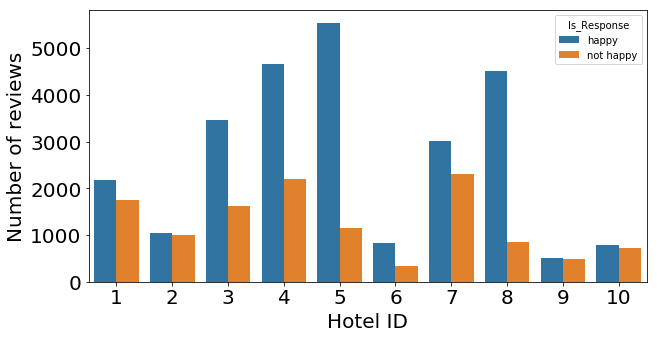

In [456]:
hotel_review_counts = df.groupby(['hotel_ID','Is_Response'])['index'].count()
hotel_review_counts = pd.DataFrame(hotel_review_counts).reset_index()
hotel_review_counts

fig,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x="hotel_ID", y="index", hue="Is_Response", data=hotel_review_counts)
ax.set_ylabel('Number of reviews')
ax.set_xlabel('Hotel ID')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

While all of the hotels have more positive than negative reviews, there are some hotels where the split is much closer to 50/50 and others where positive reviews clearly dominate. The recommendations I make to the hotel managers will likely be most helpful in cases where the proportion of negative reviews is highest.

## 2. Text preprocessing

What do some of the reviews look like?

In [457]:
print(df.Description[0])
print('')
print(df.Description[1000])
print('')
print(df.Description[30000])
print('')
print(df.Description[31000])
print('')


Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great experience. Ask for a room on the North tower, facing north west for the best views. We had a high floor, with a stunning view of the needle, the city, and even the cruise ships! We ordered room service for dinner so we could enjoy the perfect views. Room service dinners were delicious, too! You are in a perfect spot to walk everywhere, so enjoy the city. Almost forgot- Heavenly beds were heavenly, too!

last minute reservation due to disappointment with austin lake spa. excellent service,room, dining and bar service. Spa staff friendly,efficient and skillful . easy to sightsee from location. Reasonable price for a luxury hotel.

Stayed for four days in February ---- - The hotel has a great position in walking distance to Times Square, Fifth, Broadway etc etc... the room was fine, clean and a great bed. The only thing that let it down was the staff. The reception staff were dismissive and di

All of the reviews consist of unstructured text data, without any sort of keywords or tags indicating what topic they are about. In order to perform topic modeling on the reviews, I first need to preprocess the text, which will include tokenizing the reviews, lemmatizing the words, and removing stopwords. I will define a text preprocessing function to do this.

In [458]:
import nltk
import nltk.data
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

def get_lemma(word):
    Lem = WordNetLemmatizer()
    lemma = Lem.lemmatize(word)
    if lemma is None:
        return word
    else:
        return lemma

def prepare_text(text):
    re_tokenizer = RegexpTokenizer(r'\w+')
    tokens = re_tokenizer.tokenize(text.lower())
    en_stop = nltk.corpus.stopwords.words('english')

    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token for token in tokens if not token.isdigit()]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


In [459]:
df['Review_tokens'] = df['Description'].apply(lambda x: prepare_text(x))
df.head()

,index,User_ID,Description,Is_Response,hotel_ID,Review_tokens
0,0,id10329,Stayed here with husband and sons on the way t...,happy,8,"[stayed, husband, son, way, alaska, cruise, lo..."
1,1,id10331,We had - rooms. One was very nice and clearly ...,happy,3,"[room, one, nice, clearly, updated, recently, ..."
2,2,id10333,My wife & I stayed in this glorious city a whi...,happy,3,"[wife, stayed, glorious, city, back, sf, expen..."
3,3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7,"[boyfriend, stayed, fairmont, recent, trip, sa..."
4,4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3,"[step, time, square, nice, room, stayed, night..."


There are certain words that will likely appear in almost every review - for example, "hotel". I'm going to look at the most common words in all the reviews, and possibly removes words that occur too frequently! To do this, I'm going to construct a dictionary and bag of words matrix using gensim, and they calculate the frequency of each word.

In [460]:
import gensim
from gensim import corpora

text_data = df['Review_tokens']
dictionary = corpora.Dictionary(text_data)
vocab = list(dictionary.values())
corpus = [dictionary.doc2bow(text) for text in text_data]
vocab_tf={}
for i in corpus:
    for item,count in dict(i).items():
        if item in vocab_tf:
            vocab_tf[item]+=count
        else:
            vocab_tf[item] = count

Next I'll sort the vocab to find the most common words

In [461]:
vocab_tf = np.array(list(vocab_tf.values()))
ind = np.argsort(vocab_tf)[::-1]
vocab_tf_sorted = vocab_tf[ind]
vocab_sorted = np.array(vocab)[ind]

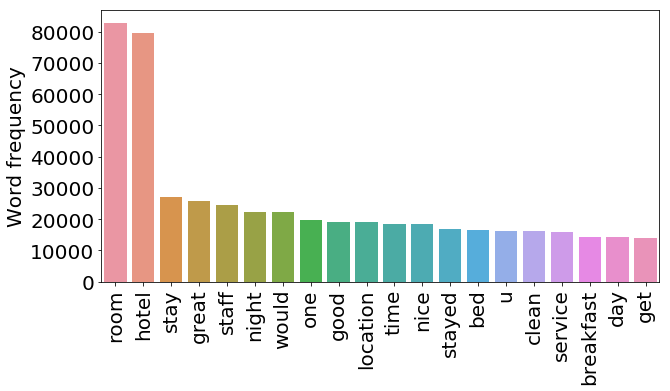

In [462]:
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=vocab_sorted[0:20], y=vocab_tf_sorted[0:20])
ax.set_ylabel('Word frequency')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_rotation(90)


The words room and hotel show up at much a higher frequency than any other word, suggesting they are in the majority of the reviews. This suggests they won't be useful in the topic modeling, so I will definitely remove those. I'm also going to remove words like stay, stayed, and would because I don't think that will be very helpful for identifying useful topics. There are also some common mispellings that I removed manually.

There are a lot of words related to sentiment as well, like good and great. I actually think that the sentiment words are unnecessary for the topic modeling, since we're trying to cluster reviews by topic not by sentiment. In order to remove them, I will get rid of all words that have a Vader rating greater than or less than some value. I chose this value, somewhat arbirtrarily to be 0.42 (or -0.42). This is mostly because "good" falls above this and "clean" falls below this threshold.

In addition, I will try to remove all proper nouns.

The rest of these words seem pretty useful. I'll redo the text processing and rebuild the dictionary and bow matrix with the new set of words.

In [463]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

def prepare_text2(text):
    re_tokenizer = RegexpTokenizer(r'\w+')
    
    en_stop = nltk.corpus.stopwords.words('english')
    newStopWords = ['room','hotel','night','day','stay','stayed','would','wa','u','th','ha'
                    'one','like']
    en_stop.extend(newStopWords)
    
    analyser = SentimentIntensityAnalyzer()

    tokens = re_tokenizer.tokenize(text)
    tokens = [token for token,pos in pos_tag(tokens) if (pos != 'NNP' and pos != 'NNPS')]
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if not token.isdigit()]
    tokens = [get_lemma(token) for token in tokens]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token for token in tokens if abs(analyser.polarity_scores(token)['compound']) < 0.42]
    return tokens


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/celia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [464]:
df['Review_tokens2'] = df['Description'].apply(lambda x: prepare_text2(x))
df.head()

,index,User_ID,Description,Is_Response,hotel_ID,Review_tokens,Review_tokens2
0,0,id10329,Stayed here with husband and sons on the way t...,happy,8,"[stayed, husband, son, way, alaska, cruise, lo...","[husband, son, way, experience, tower, facing,..."
1,1,id10331,We had - rooms. One was very nice and clearly ...,happy,3,"[room, one, nice, clearly, updated, recently, ...","[one, clearly, updated, recently, clean, bed, ..."
2,2,id10333,My wife & I stayed in this glorious city a whi...,happy,3,"[wife, stayed, glorious, city, back, sf, expen...","[wife, city, back, expensive, found, little, l..."
3,3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7,"[boyfriend, stayed, fairmont, recent, trip, sa...","[boyfriend, recent, trip, could, recommend, ca..."
4,4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3,"[step, time, square, nice, room, stayed, night...","[step, short, visit]"


In [465]:
text_data = df['Review_tokens2']
dictionary = corpora.Dictionary(text_data)
vocab = list(dictionary.values())
corpus = [dictionary.doc2bow(text) for text in text_data]
vocab_tf={}
for i in corpus:
    for item,count in dict(i).items():
        if item in vocab_tf:
            vocab_tf[item]+=count
        else:
            vocab_tf[item] = count

Now that I have tokenized the review texts and removed the most common words, I am able to move onto the topic modeling.

## Topic Modeling

I will use Latent Dirichlet Allocation (LDA) to perform topic modeling on the reviews. I will start with 7 topics just to see what they look like. Later I will check the coherence in order to pick the ideal number of topics.

In [202]:
num_topics = 7
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, 
                                      alpha='auto', eta='auto', passes=10)

In [203]:
for i in range(lda.num_topics):
    print(i)
    print(lda.print_topic(i))

0
0.021*"bathroom" + 0.019*"bed" + 0.012*"shower" + 0.012*"small" + 0.011*"old" + 0.010*"one" + 0.010*"floor" + 0.009*"lobby" + 0.009*"tv" + 0.008*"wall"
1
0.027*"location" + 0.023*"clean" + 0.020*"breakfast" + 0.015*"staff" + 0.014*"place" + 0.011*"area" + 0.011*"walk" + 0.011*"also" + 0.011*"restaurant" + 0.010*"close"
2
0.013*"desk" + 0.012*"one" + 0.011*"get" + 0.011*"front" + 0.010*"could" + 0.010*"told" + 0.009*"got" + 0.008*"check" + 0.008*"back" + 0.008*"said"
3
0.046*"pool" + 0.041*"suite" + 0.032*"kid" + 0.024*"family" + 0.017*"child" + 0.017*"bedroom" + 0.015*"two" + 0.015*"area" + 0.012*"kitchen" + 0.011*"resort"
4
0.035*"service" + 0.034*"staff" + 0.016*"time" + 0.014*"experience" + 0.010*"year" + 0.010*"make" + 0.010*"made" + 0.008*"trip" + 0.008*"guest" + 0.008*"one"
5
0.033*"parking" + 0.020*"car" + 0.013*"view" + 0.013*"bar" + 0.011*"restaurant" + 0.010*"pool" + 0.010*"valet" + 0.010*"get" + 0.010*"center" + 0.010*"food"
6
0.059*"airport" + 0.044*"shuttle" + 0.030*"fli

So there are definitely some topics that are beginning to emerge, like the state of the room, the service, the amenities, the transportation options... I'm going to analyze the coherence in order to pick a number of topics.

In [466]:
from gensim.models import CoherenceModel

num_topics = [2,5,7,10,15,20]

model_list = []
coherence_scores = []
perplexity_scores = []

for num_topic in num_topics:
    print('Modeling with '+str(num_topic)+' topics')
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topic, id2word=dictionary, 
                                      alpha='auto', eta='auto', passes=10)
    model_list.append(lda)
    
    coherence_model = CoherenceModel(model=lda, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())
    print('Coherence: '+str(coherence_model.get_coherence()))
    
    perplexity = lda.log_perplexity(corpus)
    print('Perplexity: '+str(perplexity))


Modeling with 2 topics
Coherence: 0.386093459132024
Perplexity: -7.449819968960966
Modeling with 5 topics
Coherence: 0.44873115314635603
Perplexity: -7.886185269785326
Modeling with 7 topics
Coherence: 0.4267346185790677
Perplexity: -7.44154267249937
Modeling with 10 topics
Coherence: 0.4721665496886914
Perplexity: -7.457106415709236
Modeling with 15 topics
Coherence: 0.4739012454260219
Perplexity: -7.472968457014134
Modeling with 20 topics
Coherence: 0.4641425645420685
Perplexity: -7.484709013509864


It doesn't really seem like increasing the number of topics makes them any more coherent... Let's look at some of the words in these topics.

In [467]:
for idx,model in enumerate(model_list):
    print('')
    print('')
    print('Model : ',idx)
    for i in range(model.num_topics):
        print('Topic : ',i)
        print(lda.print_topic(i))



Model :  0
Topic :  0
0.081*"bed" + 0.042*"suite" + 0.031*"bathroom" + 0.030*"two" + 0.026*"king" + 0.026*"double" + 0.025*"small" + 0.021*"bedroom" + 0.021*"size" + 0.017*"queen"
Topic :  1
0.054*"well" + 0.046*"property" + 0.028*"staff" + 0.028*"appointed" + 0.025*"recommend" + 0.022*"maintained" + 0.022*"pet" + 0.017*"highly" + 0.011*"anyone" + 0.011*"conference"


Model :  1
Topic :  0
0.081*"bed" + 0.042*"suite" + 0.031*"bathroom" + 0.030*"two" + 0.026*"king" + 0.026*"double" + 0.025*"small" + 0.021*"bedroom" + 0.021*"size" + 0.017*"queen"
Topic :  1
0.054*"well" + 0.046*"property" + 0.028*"staff" + 0.028*"appointed" + 0.025*"recommend" + 0.022*"maintained" + 0.022*"pet" + 0.017*"highly" + 0.011*"anyone" + 0.011*"conference"
Topic :  2
0.086*"coffee" + 0.066*"breakfast" + 0.018*"maker" + 0.018*"tea" + 0.017*"egg" + 0.016*"continental" + 0.015*"hot" + 0.015*"fruit" + 0.015*"cup" + 0.014*"fridge"
Topic :  3
0.033*"business" + 0.030*"internet" + 0.021*"tv" + 0.019*"center" + 0.018*

It looks like 10 topics might be a nice balance between having distinguishable topics but not having so many topics that things get repeated or diluted. Let's train a model with 10 topics, but with a higher number of passes so that the topics converge even more.

In [473]:
num_topics = 10
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, 
                                      alpha='auto', eta='auto', 
                                      passes=30, iterations=100)



In [474]:
for i in range(lda.num_topics):
    print(i)
    print(lda.print_topic(i))

0
0.062*"service" + 0.037*"bar" + 0.021*"property" + 0.018*"star" + 0.016*"lobby" + 0.015*"ha" + 0.015*"experience" + 0.013*"food" + 0.012*"top" + 0.012*"guest"
1
0.141*"parking" + 0.098*"car" + 0.045*"valet" + 0.045*"park" + 0.032*"per" + 0.027*"motel" + 0.025*"fee" + 0.022*"garage" + 0.019*"drive" + 0.018*"cable"
2
0.073*"breakfast" + 0.035*"coffee" + 0.023*"airport" + 0.021*"internet" + 0.017*"shuttle" + 0.017*"morning" + 0.011*"included" + 0.011*"hot" + 0.011*"buffet" + 0.010*"use"
3
0.029*"floor" + 0.025*"door" + 0.016*"noise" + 0.015*"elevator" + 0.013*"people" + 0.013*"could" + 0.012*"window" + 0.012*"sleep" + 0.012*"old" + 0.011*"wall"
4
0.119*"business" + 0.055*"center" + 0.045*"conference" + 0.029*"convention" + 0.028*"meeting" + 0.021*"traveler" + 0.021*"fitness" + 0.016*"tower" + 0.012*"gym" + 0.011*"drain"
5
0.019*"desk" + 0.016*"front" + 0.015*"one" + 0.012*"back" + 0.012*"check" + 0.012*"time" + 0.011*"get" + 0.011*"got" + 0.011*"told" + 0.009*"could"
6
0.138*"pool" + 0.

Ok, for the most part these topics actually make quite a bit of sense. There are some that are vauge, but a lot of them have clear themes: 
(Note: I've since rerun the clustering algorithm, so the clusters listed above are different from these ones. The clusters I use from here on are the ones listed below.)

0. Transportation to and from the hotel
2. Value for money
3. Front desk and interactions with staff
4. Pet friendly
5. Service experience
6. Nearby attractions
7. Room quality
8. Hotel amenities - food and parking
9. Events and nightlife
10. Family friendliness

Now that I've defined these topics, I can classify the reviews by topic. Instead of just assigning one topic for each review, I will keep the top 3 topics for each review, since each review could easily cover more than one thing.


In [470]:
df['First_topic'] = np.nan
df['Second_topic'] = np.nan
df['Third_topic'] = np.nan

for ind,tokens in enumerate(df['Review_tokens2']):
    test = lda.get_document_topics(dictionary.doc2bow(tokens))
    topics = sorted(test,key=lambda x:x[1],reverse=True)
    df.loc[ind,'First_topic'] = topics[0][0]
    if topics[1][0] >= 0.1:
        df.loc[ind,'Second_topic'] = topics[1][0]
    if topics[2][0] >= 0.1:
        df.loc[ind,'Third_topic'] = topics[2][0]


In [365]:
# df2 = df[['hotel_ID','Is_Response','First_topic','Second_topic','Third_topic']]
topics = df2.melt(id_vars=['hotel_ID','Is_Response'], 
                  value_vars=['First_topic','Second_topic','Third_topic'], 
                  value_name='topic')
topics = topics.groupby(['hotel_ID','topic','Is_Response']).count().reset_index()
topics

,hotel_ID,topic,Is_Response,variable
0,1,0.0,happy,2
1,1,0.0,not happy,1
2,1,1.0,happy,1857
3,1,1.0,not happy,1641
4,1,2.0,happy,1205
5,1,2.0,not happy,1395
6,1,3.0,happy,4
7,1,3.0,not happy,9
8,1,4.0,happy,1110
9,1,4.0,not happy,622


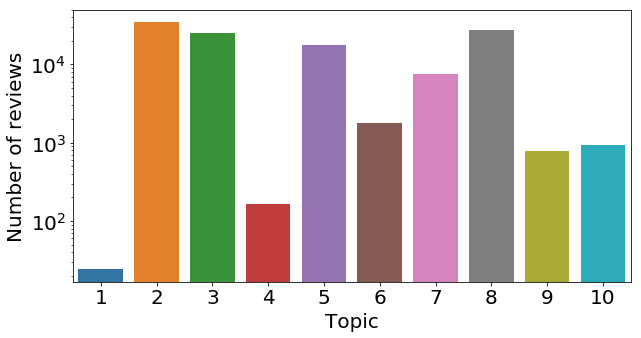

In [451]:
topics_dist = topics.groupby(['topic'])['variable'].sum()
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x = np.arange(1,11), y = topics_dist.values)
ax.set_ylabel('Number of reviews')
ax.set_xlabel('Topic')
ax.set_yscale('log')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

Certain topics show up in reviews more than others, specifically overall service and interactions with staff, value of hotel, hotel amenities, and room quality.

## Insights and Recommendations

With these topics for each review, I will be able to calculate a score for each hotel on each topic. In this case, the score ranges from 0 to 10 and is calculated from the fraction of happy responses. Lower scores mean that reviews on a particular topic tend to be negative 

In [355]:
topics_perc = topics.groupby(['hotel_ID','topic','Is_Response']).agg({'variable': 'sum'})
topics_perc = topics_perc.groupby(['hotel_ID','topic']).apply(lambda x: 10 * x / float(x.sum()))
topics_perc.reset_index(inplace=True)    
topics_perc

,hotel_ID,topic,Is_Response,variable
0,1,0.0,happy,6.666667
1,1,0.0,not happy,3.333333
2,1,1.0,happy,5.308748
3,1,1.0,not happy,4.691252
4,1,2.0,happy,4.634615
5,1,2.0,not happy,5.365385
6,1,3.0,happy,3.076923
7,1,3.0,not happy,6.923077
8,1,4.0,happy,6.408776
9,1,4.0,not happy,3.591224


Let's look at the scores for a couple of hotels. Specifically, hotels 5 and 10. Hotel 5 has a high proportion of positive to negative reviews, while Hotel 10 has almost equal numbers of both.

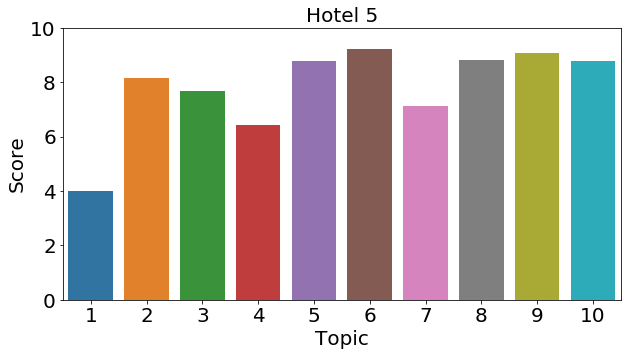

In [441]:
fig,ax = plt.subplots(figsize=(10,5))
hotel5 = topics_perc[topics_perc['hotel_ID'] == 5]
sns.barplot(x='topic',y='variable',data=hotel5[hotel5['Is_Response'] == 'happy'])
ax.set_ylabel('Score')
ax.set_xlabel('Topic')
ax.set_title('Hotel 5')
ax.set_ylim([0,10])
ax.set_xticklabels(range(1,11))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

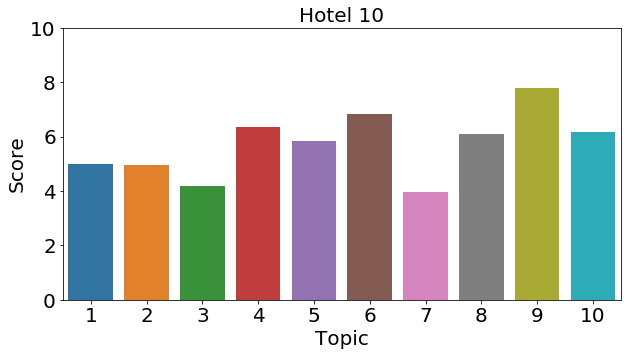

In [440]:
fig,ax = plt.subplots(figsize=(10,5))
hotel10 = topics_perc[topics_perc['hotel_ID'] == 10]
sns.barplot(x='topic',y='variable',data=hotel10[hotel10['Is_Response'] == 'happy'])
ax.set_ylabel('Score')
ax.set_xlabel('Topic')
ax.set_title('Hotel 10')
ax.set_ylim([0,10])
ax.set_xticklabels(range(1,11))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

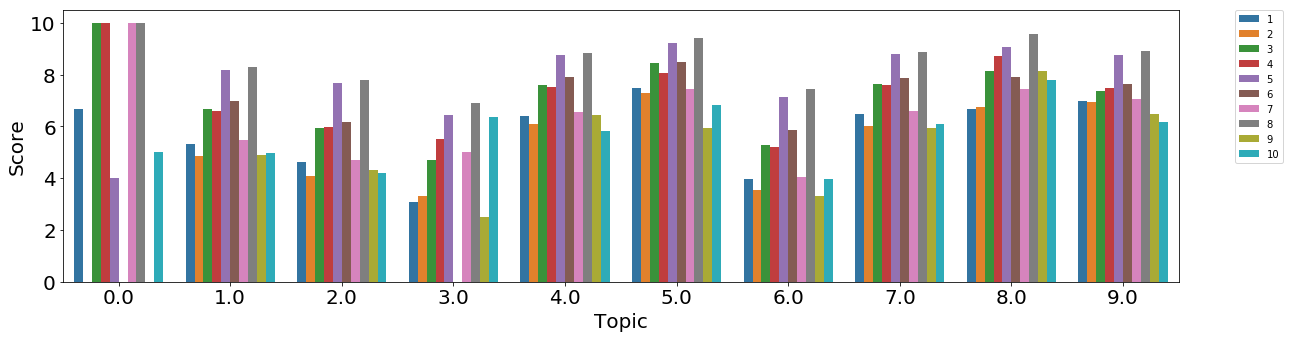

In [362]:
fig,ax = plt.subplots(figsize=(20,5))
sns.barplot(x='topic',y='variable',hue='hotel_ID',data=topics_perc[topics_perc['Is_Response'] == 'happy'])
ax.set_ylabel('Score')
ax.set_xlabel('Topic')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


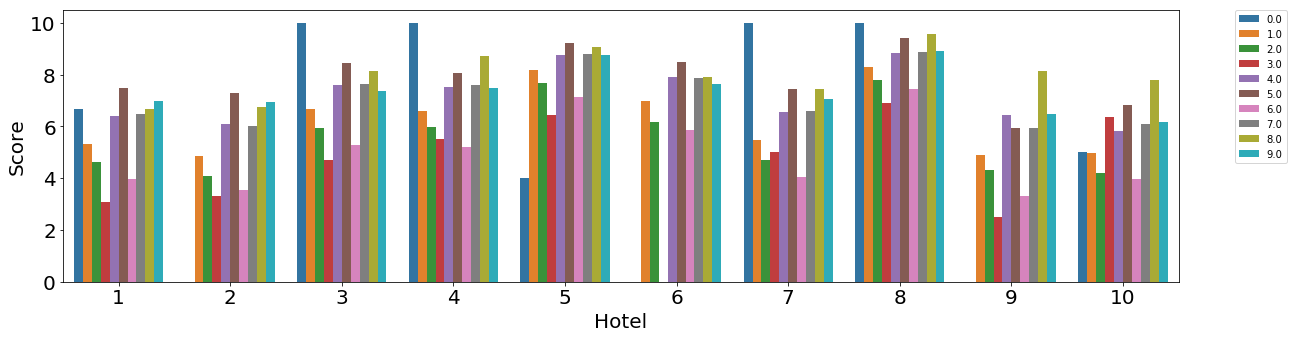

In [363]:
fig,ax = plt.subplots(figsize=(20,5))
sns.barplot(x='hotel_ID',y='variable',hue='topic',data=topics_perc[topics_perc['Is_Response'] == 'happy'])
ax.set_ylabel('Score')
ax.set_xlabel('Hotel')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Clearly certain hotels do better with certain topics than others. For each hotel, I can find the topic with the worst score. It might also be good to weight these by how many reviews there are, because clearly the topics that get the most reviews are the most important to customers at those hotels.

In [391]:
for hotel in topics_perc.hotel_ID.unique():
    hotel_scores = topics_perc[topics_perc['hotel_ID'] == hotel]
    hotel_scores = hotel_scores[hotel_scores['Is_Response'] == 'happy']
    worst_topic = hotel_scores.topic[np.argmin(hotel_scores.variable)]
    best_topic = hotel_scores.topic[np.argmax(hotel_scores.variable)]
    
    hotel_count = topics[topics['hotel_ID'] == hotel]
    worst_topic_count = hotel_count[hotel_count.topic == worst_topic]['variable'].sum()
    best_topic_count = hotel_count[hotel_count.topic == best_topic]['variable'].sum()
    total_count = hotel_count['variable'].sum()
    
    print('The worst topic for hotel ',hotel,' is number: ',worst_topic)
    print('This topic is ', 100*worst_topic_count/total_count,'% of reviews for this hotel')
    print('The best topic for hotel ',hotel,' is number: ',best_topic)
    print('This topic is ', 100*best_topic_count/total_count,'% of reviews for this hotel')
    print('')

The worst topic for hotel  1  is number:  3.0
This topic is  0.11061946902654868 % of reviews for this hotel
The best topic for hotel  1  is number:  5.0
This topic is  1.5827093260721579 % of reviews for this hotel

The worst topic for hotel  2  is number:  3.0
This topic is  0.19461563412260785 % of reviews for this hotel
The best topic for hotel  2  is number:  5.0
This topic is  1.4433992864093415 % of reviews for this hotel

The worst topic for hotel  3  is number:  3.0
This topic is  0.11181268087345435 % of reviews for this hotel
The best topic for hotel  3  is number:  0.0
This topic is  0.03946329913180742 % of reviews for this hotel

The worst topic for hotel  4  is number:  6.0
This topic is  6.641616240484091 % of reviews for this hotel
The best topic for hotel  4  is number:  0.0
This topic is  0.014639859457349209 % of reviews for this hotel

The worst topic for hotel  5  is number:  0.0
This topic is  0.024996250562415636 % of reviews for this hotel
The best topic for ho

So the worst and best topics tend to not be the most common topics in reviews. I will rank the topics by the number of reviews they each get, and then find the first one with a "bad" score:

In [442]:
for hotel in topics_perc.hotel_ID.unique():
    print('Hotel number ',hotel)
    hotel_scores = topics_perc[topics_perc['hotel_ID'] == hotel]
    hotel_scores = hotel_scores[hotel_scores['Is_Response'] == 'happy'].reset_index()
    topics_sorted = hotel_scores.topic[np.argsort(hotel_scores.variable).values]
    scores_sorted = hotel_scores.variable[np.argsort(hotel_scores.variable).values]

    hotel_count = topics[topics['hotel_ID'] == hotel]
    total_count = hotel_count['variable'].sum()

    for idx in topics_sorted.index:
        topic = topics_sorted[idx]
        topic_count = hotel_count[hotel_count.topic == topic]['variable'].sum()
        print('Topic ', topic+1, ' represents ', round(100*topic_count/total_count,1), '% of reviews for this hotel',
             ' and it has a score of ', round(scores_sorted[idx],2))
    print('')
        
        

Hotel number  1
Topic  4.0  represents  0.1 % of reviews for this hotel  and it has a score of  3.08
Topic  7.0  represents  7.3 % of reviews for this hotel  and it has a score of  3.97
Topic  3.0  represents  22.1 % of reviews for this hotel  and it has a score of  4.63
Topic  2.0  represents  29.8 % of reviews for this hotel  and it has a score of  5.31
Topic  5.0  represents  14.7 % of reviews for this hotel  and it has a score of  6.41
Topic  8.0  represents  22.9 % of reviews for this hotel  and it has a score of  6.46
Topic  1.0  represents  0.0 % of reviews for this hotel  and it has a score of  6.67
Topic  9.0  represents  0.7 % of reviews for this hotel  and it has a score of  6.67
Topic  10.0  represents  0.8 % of reviews for this hotel  and it has a score of  6.98
Topic  6.0  represents  1.6 % of reviews for this hotel  and it has a score of  7.47

Hotel number  2
Topic  4.0  represents  0.2 % of reviews for this hotel  and it has a score of  3.33
Topic  7.0  represents  7.2

By looking at the topics in terms of both scores and number of reviews, we can find the most commonly reviewed topics that are problems for a particular hotel. These topics can form the basis for the recommendations we make to the hotel managers for how to improve customer satisfaction. 

## Conclusions

- Hotel reviews can be clustered into ten distinct topics, from which we can calculate an overall score for that hotel


- Most hotels can improve the overall experience for their customers by improving customer service, improving value by reducing prices, and by improving room quality


- Most customers don't care very much about things like transportation to and from the hotel and pet-friendliness, at least based on the frequency at which these topics come up in reviews